In [1]:
# import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# load the cleaned training and test datasets
df_train = pd.read_csv('removed_training.csv')
df_test = pd.read_csv('removed_test.csv')

df_test['tweet'] = df_test['tweet'].fillna('')  # replace NaN with empty string
df_train['tweet'] = df_train['tweet'].fillna('')

# extract tweets and labels
tweets_train = df_train['tweet']
labels_train = df_train['label']
tweets_test = df_test['tweet']
labels_test = df_test['label']

In [2]:
# encode labels if they are not numeric
label_encoder = LabelEncoder()
labels_train = label_encoder.fit_transform(labels_train)
labels_test = label_encoder.transform(labels_test)

# vectorize tweets using CountVectorizer
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
tweet_vectors_train = vectorizer.fit_transform(tweets_train)
tweet_vectors_test = vectorizer.transform(tweets_test)

# apply LDA for topic modeling
num_topics = 10  # adjust this number based on dataset
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=39)
lda_features_train = lda_model.fit_transform(tweet_vectors_train)
lda_features_test = lda_model.transform(tweet_vectors_test)


In [15]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=39),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=39),
    "Random Forest": RandomForestClassifier(random_state=39),
    "SVM": SVC(random_state=39)
}

# train and evaluate each classifier
results = {}

for name, clf in classifiers.items():
    # train the classifier
    clf.fit(lda_features_train, labels_train)
    
    # make predictions on the test set
    predictions = clf.predict(lda_features_test)
    
    # evaluate the model
    accuracy = round(accuracy_score(labels_test, predictions), 2)
    print(f"=== {name} ===")
    print(classification_report(labels_test, predictions, target_names=label_encoder.classes_))
    print(f"Accuracy: {accuracy}")
    print()
    
    # store results for comparison
    results[name] = {"model": clf, "accuracy": accuracy}

# compare performance
for name, metrics in results.items():
    print(f"{name}: Accuracy = {metrics['accuracy']}")


=== Logistic Regression ===
              precision    recall  f1-score   support

         bot       0.93      0.77      0.84      1320
       human       0.80      0.94      0.87      1320

    accuracy                           0.85      2640
   macro avg       0.86      0.85      0.85      2640
weighted avg       0.86      0.85      0.85      2640

Accuracy: 0.85

=== Gradient Boosting Classifier ===
              precision    recall  f1-score   support

         bot       0.93      0.79      0.86      1320
       human       0.82      0.94      0.88      1320

    accuracy                           0.87      2640
   macro avg       0.88      0.87      0.87      2640
weighted avg       0.88      0.87      0.87      2640

Accuracy: 0.87

=== Random Forest ===
              precision    recall  f1-score   support

         bot       0.93      0.81      0.87      1320
       human       0.83      0.94      0.88      1320

    accuracy                           0.87      2640
   macro 

In [16]:
import numpy as np

# get the topic-word distributions
topic_word_distributions = lda_model.components_  # shape: (num_topics, num_words)
vocabulary = vectorizer.get_feature_names_out()  # words corresponding to each column in the topic matrix

# function to get top words for a given topic
def get_top_words(topic_idx, n_words=10):
    # get indices of the top words for the topic
    top_word_indices = topic_word_distributions[topic_idx].argsort()[-n_words:][::-1]
    return [vocabulary[i] for i in top_word_indices]

# group topic distributions by labels
topic_distributions_by_label = {label: [] for label in np.unique(labels_train)}

for label, topic_dist in zip(labels_train, lda_features_train):
    topic_distributions_by_label[label].append(topic_dist)

# compute average topic distribution for each label
avg_topic_distribution_by_label = {
    label: np.mean(distributions, axis=0)
    for label, distributions in topic_distributions_by_label.items()
}

# identify the most indicative topics for each label
print("Most indicative topics for each label:\n")
for label, avg_topic_distribution in avg_topic_distribution_by_label.items():
    # get indices of the top topics for the label
    top_topics = avg_topic_distribution.argsort()[-5:][::-1]  # top 5 topics
    print(f"Label {label_encoder.inverse_transform([label])[0]}:")
    for topic_idx in top_topics:
        top_words = get_top_words(topic_idx, n_words=10)
        print(f"  Topic {topic_idx}: {', '.join(top_words)}")
    print()


Most indicative topics for each label:

Label bot:
  Topic 9: read, history, great, check, life, learn, introduction, don, people, man
  Topic 6: developer, job, engineer, software, senior, description, location, manager, analyst, amp
  Topic 5: just, like, don, amp, people, time, good, day, love, ve
  Topic 8: trump, president, new, news, says, donald, house, repo, tv, white
  Topic 7: new, brexit, social, amp, media, facebook, business, sharing, means, repo

Label human:
  Topic 5: just, like, don, amp, people, time, good, day, love, ve
  Topic 8: trump, president, new, news, says, donald, house, repo, tv, white
  Topic 7: new, brexit, social, amp, media, facebook, business, sharing, means, repo
  Topic 9: read, history, great, check, life, learn, introduction, don, people, man
  Topic 3: free, retweet, site, win, plz, job, green, follow, tweets, blue



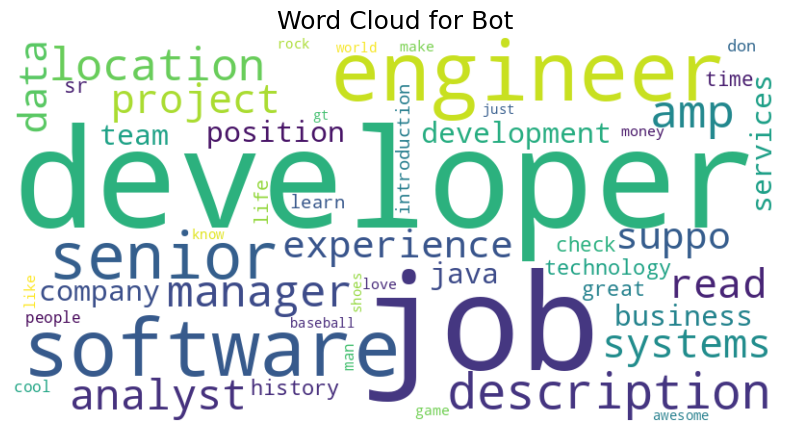

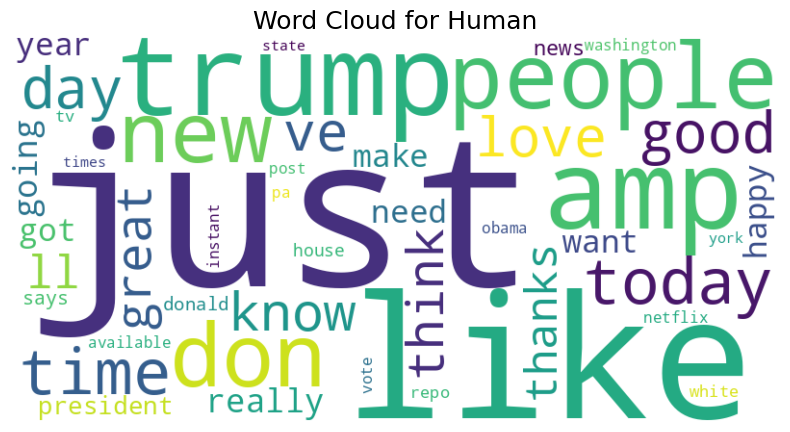

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# get the top words for the most indicative topics for each label
def get_label_words(label, n_topics=2, n_words=25):
    # get the most indicative topics for this label
    avg_topic_distribution = avg_topic_distribution_by_label[label]
    top_topic_indices = avg_topic_distribution.argsort()[-n_topics:][::-1]  # top `n_topics`
    
    # collect top words from these topics
    label_words = {}
    for topic_idx in top_topic_indices:
        top_word_indices = topic_word_distributions[topic_idx].argsort()[-n_words:][::-1]
        for i in top_word_indices:
            word = vocabulary[i]
            weight = topic_word_distributions[topic_idx, i]
            label_words[word] = label_words.get(word, 0) + weight  # sum weights across topics
    
    return label_words

# generate Word Cloud
def create_word_cloud(words, label_name):
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white'
    ).generate_from_frequencies(words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {label_name}", fontsize=18)
    plt.show()

# generate Word Clouds for Bot and Human
bot_label = label_encoder.transform(['bot'])[0]  # numeric label for "bot"
human_label = label_encoder.transform(['human'])[0]  # numeric label for "human"

bot_words = get_label_words(bot_label)
human_words = get_label_words(human_label)

create_word_cloud(bot_words, "Bot")
create_word_cloud(human_words, "Human")
